In [1]:
import importlib as imt
import datasets_v3 as ds
import frame_autoencoder_v3 as fr
imt.reload(ds)
imt.reload(fr)

<module 'frame_autoencoder_v3' from '/home/ubuntu/amzbinimg/src/frame_autoencoder_v3.py'>

In [2]:
import datetime as dt
import tensorflow as tf

import skimage
from skimage.io import imread
from skimage.io import imsave
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dense, Input, InputLayer
from tensorflow.keras.layers import Conv2D, Flatten
from tensorflow.keras.layers import Reshape, Conv2DTranspose
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K
from tensorflow.keras.datasets import mnist
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.activations import relu
from tensorflow.keras.layers import UpSampling2D, MaxPooling2D

## Reconstruct Autoencoder

### load datasets for reconstruction

In [3]:
frame = fr.frame_autoencoder(batch_size = 128, 
                            kernel_size = 3, 
                            latent_dim = 1024, 
                            layer_filters = [16, 32, 16]
    )
frame.load_and_condition_dataset_reco()

### Build Customer Encoder and Decoder

In [16]:
frame.load_encoder(build_encoder)
frame.load_decoder(build_decoder)

### Build AutoEncoder

In [20]:
frame.load_autoencoder(build_autoencoder)

In [21]:
frame.encoder.summary()

Model: "encoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encoder_input (InputLayer)   [(None, 128, 128, 3)]     0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 128, 128, 16)      448       
_________________________________________________________________
batch_normalization_6 (Batch (None, 128, 128, 16)      64        
_________________________________________________________________
tf_op_layer_Relu_6 (TensorFl multiple                  0         
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 64, 64, 16)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 64, 64, 32)        4640      
_________________________________________________________________
batch_normalization_7 (Batch (None, 64, 64, 32)        128 

In [22]:
frame.decoder.summary()

Model: "decoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
decoder_input (InputLayer)   [(None, 1024)]            0         
_________________________________________________________________
dense_1 (Dense)              (None, 4096)              4198400   
_________________________________________________________________
reshape_1 (Reshape)          (None, 16, 16, 16)        0         
_________________________________________________________________
conv2d_transpose_4 (Conv2DTr (None, 16, 16, 16)        2320      
_________________________________________________________________
batch_normalization_9 (Batch (None, 16, 16, 16)        64        
_________________________________________________________________
tf_op_layer_Relu_9 (TensorFl multiple                  0         
_________________________________________________________________
up_sampling2d_3 (UpSampling2 (None, 32, 32, 16)        0   

In [23]:
frame.autoencoder.summary()

Model: "autoencoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encoder_input (InputLayer)   [(None, 128, 128, 3)]     0         
_________________________________________________________________
encoder (Model)              (None, 1024)              4205296   
_________________________________________________________________
decoder (Model)              (None, 128, 128, 3)       4210675   
Total params: 8,415,971
Trainable params: 8,415,459
Non-trainable params: 512
_________________________________________________________________


In [24]:
log_dir="../logs/autoencoder_reco/train/" + dt.datetime.now().strftime("%Y%m%d-%H%M%S")
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=0.0001)
tensorboard = TensorBoard(log_dir=log_dir, histogram_freq=2)
history = frame.autoencoder.fit(x=frame.Xf_train,
                y=frame.yf_train,
                epochs=40,
                validation_split=0.2,
                batch_size=frame.batch_size,
                callbacks = [tensorboard],
                use_multiprocessing=True
)

Train on 21104 samples, validate on 5276 samples
Epoch 1/40
21104/21104 [==============================] - 52s 2ms/sample - loss: 0.6666 - val_loss: 0.6551
Epoch 2/40
21104/21104 [==============================] - 46s 2ms/sample - loss: 0.6510 - val_loss: 0.6491
Epoch 3/40
21104/21104 [==============================] - 47s 2ms/sample - loss: 0.6477 - val_loss: 0.6474
Epoch 4/40
21104/21104 [==============================] - 46s 2ms/sample - loss: 0.6464 - val_loss: 0.6464
Epoch 5/40
21104/21104 [==============================] - 47s 2ms/sample - loss: 0.6457 - val_loss: 0.6458
Epoch 6/40
21104/21104 [==============================] - 46s 2ms/sample - loss: 0.6452 - val_loss: 0.6454
Epoch 7/40
21104/21104 [==============================] - 47s 2ms/sample - loss: 0.6449 - val_loss: 0.6452
Epoch 8/40
21104/21104 [==============================] - 46s 2ms/sample - loss: 0.6446 - val_loss: 0.6448
Epoch 9/40
21104/21104 [==============================] - 47s 2ms/sample - loss: 0.6443 - val_l

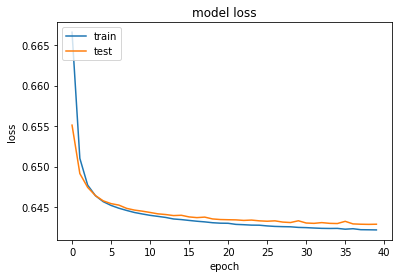

In [25]:
fr.plot_history(history)

In [26]:
log_dir="../logs/autoencoder/evaluate/" + dt.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard = TensorBoard(log_dir=log_dir, histogram_freq=1)    
frame.autoencoder.evaluate(x=frame.Xf_test, 
                        y=frame.yf_test, 
                        batch_size=frame.batch_size, 
                        verbose=2, 
                        callbacks=[tensorboard], 
                        #max_queue_size=10, 
                        #workers=1, 
                        use_multiprocessing=False
)

2932/1 - 3s - loss: 0.6432


0.642859868186883

In [33]:
import pickle
with open('../model/history_reco_binary_6428.pkl', 'wb') as file_pi:
        pickle.dump(history.history, file_pi)
frame.autoencoder.reset_metrics()
frame.autoencoder.save("../model/autoencoder_reco_binary_6428.h5")
frame.encoder.save("../model/encoder_reco_binary_6428.h5")
frame.decoder.save("../model/decoder_reco_binary_6428.h5")

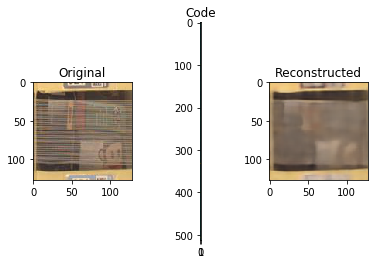

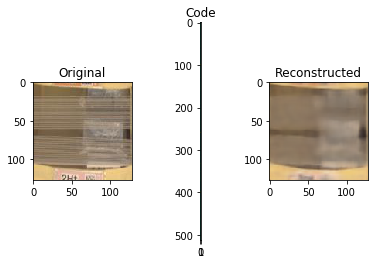

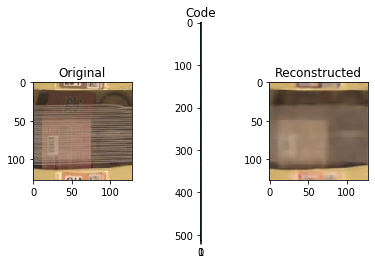

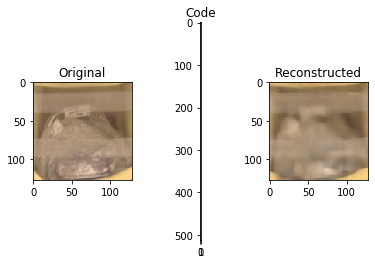

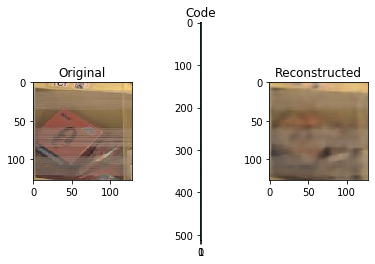

In [39]:
for i in range(0,5):
        img = frame.Xf_test[i]
        fr.visualize(img,frame.encoder,frame.decoder)

In [40]:
# frame = fr.frame_autoencoder(batch_size = 64, 
#                             kernel_size = 3, 
#                             latent_dim = 256, 
#                             layer_filters = [64, 32, 16]
#     )
# frame.load_and_condition_dataset_feature_extraction()

frame.load_and_condition_dataset_denoise('../data/x_images_v2/', '../data/y_images_v2/')

In [35]:
frame.autoencoder = tf.keras.models.load_model("../model/autoencoder_reco_binary.h5")
frame.encoder = tf.keras.models.load_model("../model/encoder_reco_binary.h5")
frame.decoder = tf.keras.models.load_model("../model/decoder_reco_binary.h5")

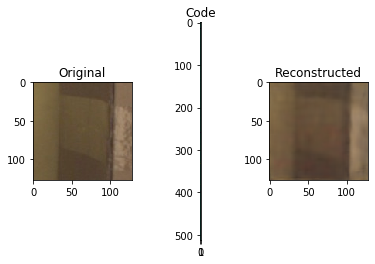

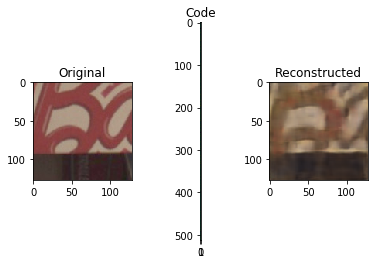

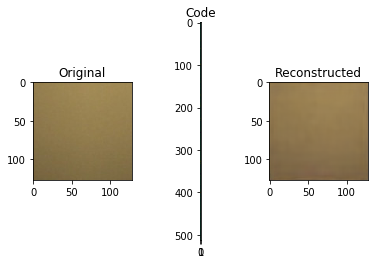

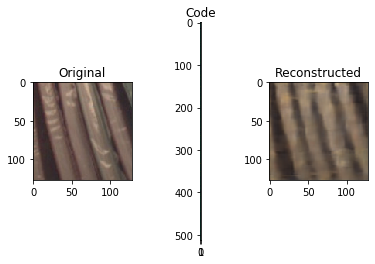

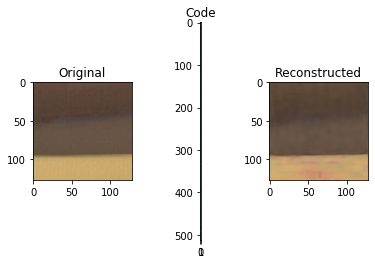

In [41]:
for i in range(5):
        img = frame.y_train[i]
        fr.visualize(img, frame.encoder,frame.decoder)

In [42]:
frame.autoencoder.reset_metrics()
frame.encoder.trainable = False
optimizer = tf.keras.optimizers.Adam(
    learning_rate=0.0001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, amsgrad=False,
    name='Adam'
)
frame.autoencoder.compile(loss='mse', optimizer=optimizer, sample_weight_mode="temporal")
log_dir="../logs/denoise/train/" + dt.datetime.now().strftime("%Y%m%d-%H%M%S")
#callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=0.001)
tensorboard = TensorBoard(log_dir=log_dir, histogram_freq=1)
history = frame.autoencoder.fit(x=frame.X_train,
                y=frame.y_train,
                epochs=20,
                validation_split=0.1,
                batch_size=32,
                callbacks = [tensorboard],
                use_multiprocessing=False
)

Train on 7217 samples, validate on 802 samples
Epoch 1/20
7217/7217 [==============================] - 14s 2ms/sample - loss: 0.0029 - val_loss: 0.0021
Epoch 2/20
7217/7217 [==============================] - 12s 2ms/sample - loss: 0.0018 - val_loss: 0.0016
Epoch 3/20
7217/7217 [==============================] - 12s 2ms/sample - loss: 0.0014 - val_loss: 0.0014
Epoch 4/20
7217/7217 [==============================] - 12s 2ms/sample - loss: 0.0012 - val_loss: 0.0012
Epoch 5/20
7217/7217 [==============================] - 12s 2ms/sample - loss: 0.0011 - val_loss: 0.0011
Epoch 6/20
7217/7217 [==============================] - 12s 2ms/sample - loss: 9.8412e-04 - val_loss: 0.0010
Epoch 7/20
7217/7217 [==============================] - 12s 2ms/sample - loss: 9.0852e-04 - val_loss: 9.4244e-04
Epoch 8/20
7217/7217 [==============================] - 12s 2ms/sample - loss: 8.4673e-04 - val_loss: 8.8931e-04
Epoch 9/20
7217/7217 [==============================] - 12s 2ms/sample - loss: 7.9769e-04 - v

In [43]:
log_dir="../logs/denoise/train/" + dt.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard = TensorBoard(log_dir=log_dir, histogram_freq=1)    
frame.autoencoder.evaluate(x=frame.X_test, 
                        y=frame.y_test, 
                        batch_size=frame.batch_size, 
                        verbose=2, 
                        callbacks=[tensorboard], 
                        #max_queue_size=10, 
                        #workers=1, 
                        use_multiprocessing=False
)

891/891 - 1s - loss: 6.0387e-04


0.0006038668466414148

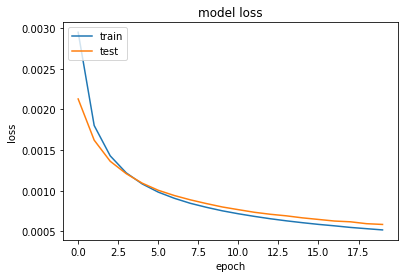

In [44]:
fr.plot_history(history)

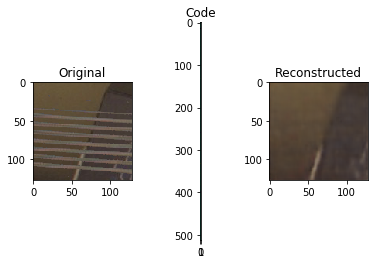

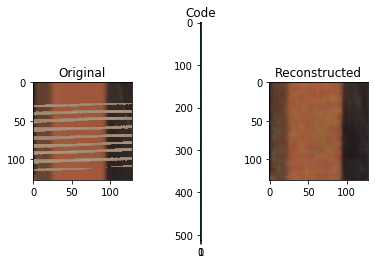

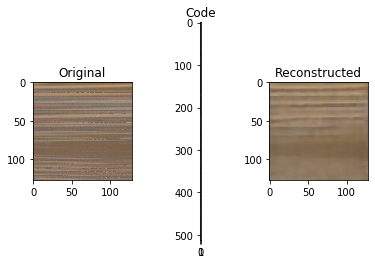

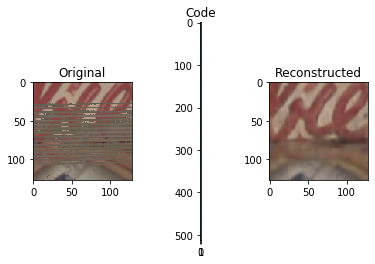

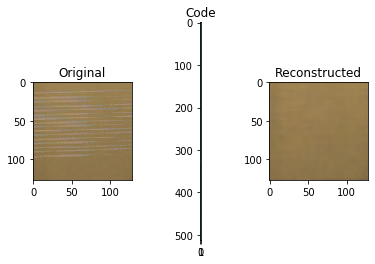

In [45]:
for i in range(5):
        img = frame.X_test[i]
        fr.visualize(img, frame.encoder,frame.decoder)

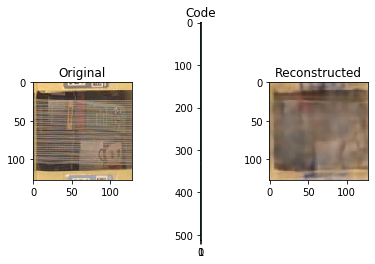

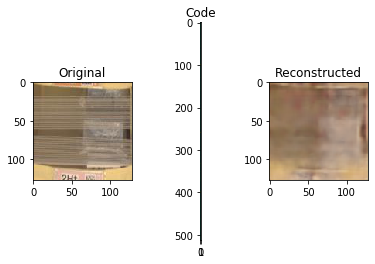

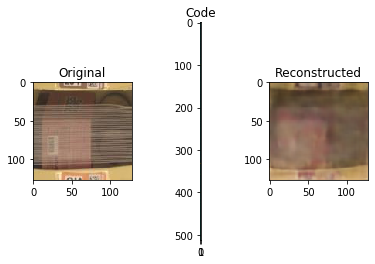

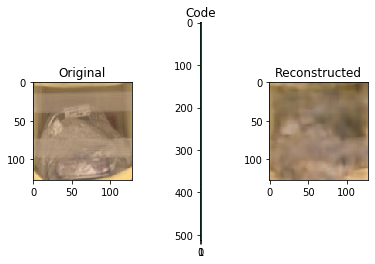

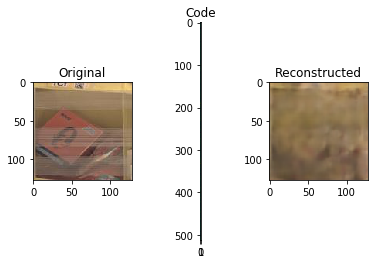

In [47]:
for i in range(5):
        img = frame.Xf_test[i]
        fr.visualize(img,frame.encoder,frame.decoder)

In [48]:
import gc
gc.collect()

81691

In [24]:
dt.datetime.now()

datetime.datetime(2020, 2, 27, 22, 28, 42, 429503)

datetime.datetime(2020, 2, 27, 22, 28, 42, 429503)


In [25]:
from tensorflow.keras.callbacks import TensorBoard

In [2]:
!tensorboard --logdir '/home/ubuntu/amzbinimg/logs/autoencoder/train'

Serving TensorBoard on localhost; to expose to the network, use a proxy or pass --bind_all
TensorBoard 2.0.1 at http://localhost:6006/ (Press CTRL+C to quit)
^C


In [47]:
image = frame.X_test[1]

In [33]:
image.shape

(128, 128, 3)

In [34]:
type(image)

numpy.ndarray

In [54]:
pre = frame.encoder.predict(image[None])

In [36]:
len(pre)

1

In [55]:
pre = pre[0]

In [38]:
pre.shape

(252,)

In [39]:
type(pre)

numpy.ndarray

In [56]:
pre = pre[::-1]

In [57]:
reco = frame.decoder.predict(pre[None])[0]

In [4]:
def build_encoder(frame):
    inputs = Input(shape=frame.input_shape, name='encoder_input')
    x = inputs

    x = Conv2D(filters=16, kernel_size=frame.kernel_size, strides=1, padding='same')(x)
    x = BatchNormalization(trainable=False)(x)
    x = relu(x)
    x = MaxPooling2D(pool_size = (2, 2), padding='same')(x)

    x = Conv2D(filters=32, kernel_size=frame.kernel_size, strides=1, padding='same')(x)
    x = BatchNormalization(trainable=False)(x)
    x = relu(x)
    x = MaxPooling2D(pool_size = (2, 2), padding='same')(x)

    x = Conv2D(filters=16, kernel_size=frame.kernel_size, strides=1, padding='same')(x)
    x = BatchNormalization(trainable=False)(x)
    x = relu(x)
    x = MaxPooling2D(pool_size = (2, 2), padding='same')(x)

    
    # Shape info needed to build Decoder Model
    frame.shape = K.int_shape(x)
    # Generate the latent vector
    x = Flatten()(x)
    latent = Dense(frame.latent_dim, name='latent_vector')(x)

    # Instantiate Encoder Model
    frame.encoder = Model(inputs, latent, name='encoder')
    frame.inputs = inputs

In [15]:
def build_decoder(frame):

    latent_inputs = Input(shape=(frame.latent_dim,), name='decoder_input')
    x = Dense(frame.shape[1] * frame.shape[2] * frame.shape[3])(latent_inputs)
    x = Reshape((frame.shape[1], frame.shape[2], frame.shape[3]))(x)


    x = Conv2DTranspose(filters=16, kernel_size=frame.kernel_size, strides=1, padding='same')(x)
    x = BatchNormalization(trainable=False)(x)
    x = relu(x)
    x = UpSampling2D((2, 2))(x)

    x = Conv2DTranspose(filters=32, kernel_size=frame.kernel_size, strides=1, padding='same')(x)
    x = BatchNormalization(trainable=False)(x)
    x = relu(x)
    x = UpSampling2D((2, 2))(x)

    x = Conv2DTranspose(filters=16, kernel_size=frame.kernel_size, strides=1, padding='same')(x)
    x = BatchNormalization(trainable=False)(x)
    x = relu(x)
    x = UpSampling2D((2, 2))(x)

    x = Conv2DTranspose(filters=3, kernel_size=frame.kernel_size, padding='same')(x)

    outputs = Activation('sigmoid', name='decoder_output')(x)

    # Instantiate Decoder Model
    frame.decoder = Model(latent_inputs, outputs, name='decoder')

In [17]:
def build_autoencoder(frame):
    frame.autoencoder = Model(frame.inputs, frame.decoder(frame.encoder(frame.inputs)), name='autoencoder')
    optimizer = tf.keras.optimizers.Adam(
                    learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, amsgrad=False,
                    name='Adam'
                )
    frame.autoencoder.compile(loss='binary_crossentropy', optimizer=optimizer)

In [92]:
code = frame.encoder.predict(frame.Xf_test[1][None])[0]

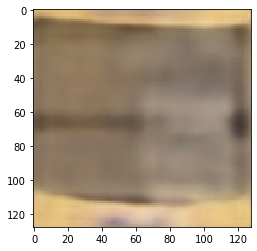

In [95]:
reco = frame.decoder.predict(code[None])[0]
plt.imshow(reco)

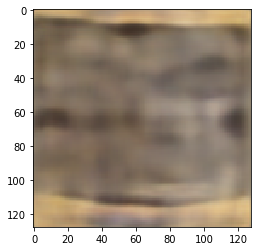

In [96]:
# mask = np.zeros(code.shape[0])
# mask[code >= 0.70] = 0
new_code = code.copy()
new_code[code <= -0.5] = 0
reco = frame.decoder.predict(new_code[None])[0]
plt.imshow(reco)

In [59]:
code[code >=0.70]

array([0.73644143, 0.763427  , 0.83547187], dtype=float32)

In [26]:
def visualize_features(img, encoder, decoder):
    code = encoder.predict(img[None])[0]
    
    images_per_row = 16
    num_of_features = code.shape[0]
    n_cols =  num_of_features // images_per_row
    display_grid = np.zeros((images_per_row, n_cols))
    
    for row in range(images_per_row):
        for col in range(n_cols):
            mask = np.zeros(num_of_features)
            mask[row * n_cols + col] = 1
            new_code = code.copy()
            new_code = new_code * mask
            reco = decoder.predict(new_code[None])[0]
            display_grid[row, col] = reco
    
    plt.figure(figsize= (images_per_row, n_cols))
    plt.title("Feature Representation by Decoder")
    plt.grid(False)
    plt.imshow(display_grid, aspect='auto', cmap='viridis')

16-32-64 64-32-16 512 latent 0.24